Peclet numbers (x-direction):
[0.00000000e+00 3.43154250e-10 8.08224000e-10 1.09170975e-09
 1.46438915e-09 1.94608100e-09 2.55451935e-09 3.29957750e-09
 4.17464000e-09 5.14616750e-09 6.14506000e-09 7.06623000e-09
 7.78295250e-09 8.17728000e-09 8.17729000e-09 7.78297500e-09
 7.06622500e-09 6.14505000e-09 5.14617500e-09 4.17465000e-09
 3.29957500e-09 2.55450000e+01 1.94607500e+01 1.46440000e+01
 1.09172500e+01 8.08225000e+00]


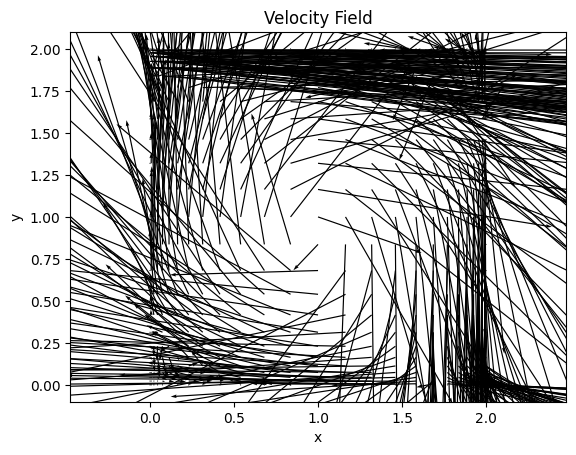

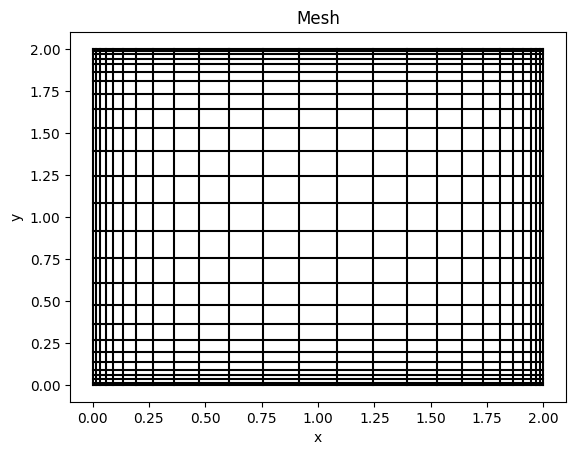

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load data ---
xc = np.loadtxt('xc.dat')
yc = np.loadtxt('yc.dat')
u = np.loadtxt('u.dat')
v = np.loadtxt('v.dat')

# --- Determine grid sizes ---
nim1 = len(xc)        # number of grid lines
ni = nim1 + 1         # number of nodes in x-direction
njm1 = len(yc)
nj = njm1 + 1

# --- Reshape u and v to 2D arrays ---
u2d = np.reshape(u, (ni, nj), order='F')  # 'F' = column-major (MATLAB style)
v2d = np.reshape(v, (ni, nj), order='F')

# --- Compute cell-center coordinates ---
xp = np.zeros(ni)
yp = np.zeros(nj)

for i in range(1, nim1):
    xp[i] = 0.5 * (xc[i] + xc[i-1])
xp[0] = xc[0]
xp[-1] = xc[-1]

for j in range(1, njm1):
    yp[j] = 0.5 * (yc[j] + yc[j-1])
yp[0] = yc[0]
yp[-1] = yc[-1]

# --- Plot velocity field ---
vec = 5
plt.figure()
plt.quiver(xp, yp, u2d, v2d, scale=1/vec)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity Field')

# --- Plot mesh ---
plt.figure()
X, Y = np.meshgrid(xc, yc)
plt.plot(X, yc[:, None], 'k-')   # horizontal lines
plt.plot(xc, Y.T, 'k-')          # vertical lines
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mesh')

# --- Compute Δx and Δy between cell centers ---
d_x = np.diff(xp)
d_y = np.diff(yp)

# --- Compute Peclet number ---
rho = 1
gamma = 1/500
Pe = np.zeros(nim1)
for i in range(1, nim1):
    Pe[i] = rho * u2d[i, 0] * d_x[i-1] / gamma   # taking u along one j-line (e.g. j=0)

print("Peclet numbers (x-direction):")
print(Pe)

plt.show()

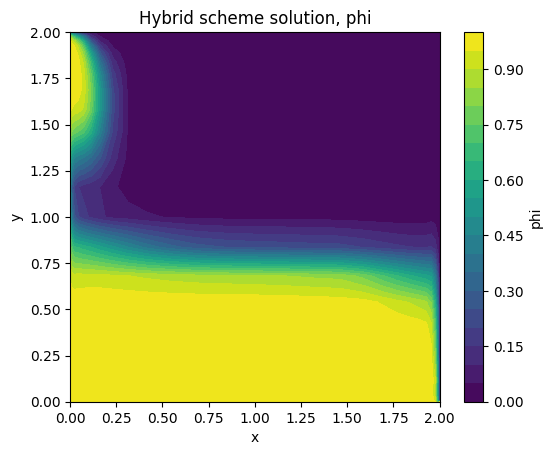

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load data ---
xc = np.loadtxt('xc.dat')   # length = nim1
yc = np.loadtxt('yc.dat')   # length = njm1
u = np.loadtxt('u.dat')     # length = ni*nj (MATLAB column-major ordering)
v = np.loadtxt('v.dat')

# --- Determine grid sizes ---
nim1 = len(xc)        # number of cell faces / grid-lines in x
ni = nim1 + 1         # number of nodes in x
njm1 = len(yc)        # number of cell faces / grid-lines in y
nj = njm1 + 1         # number of nodes in y

# --- Reshape u and v to 2D arrays (MATLAB column-major -> order='F') ---
u2d = np.reshape(u, (ni, nj), order='F')
v2d = np.reshape(v, (ni, nj), order='F')

# --- Compute cell-center coordinates (xp length = ni, yp length = nj) ---
xp = np.zeros(ni)
xp[1:nim1] = 0.5 * (xc[1:] + xc[:-1])   # interior cell-centres
xp[0] = xc[0]
xp[-1] = xc[-1]

yp = np.zeros(nj)
yp[1:njm1] = 0.5 * (yc[1:] + yc[:-1])
yp[0] = yc[0]
yp[-1] = yc[-1]

# distances between adjacent cell centers (length = nim1, njm1)
d_x = np.diff(xp)   # len = ni-1 = nim1
d_y = np.diff(yp)   # len = nj-1 = njm1

# ---- Physical parameters ----
rho = 1.0
gamma = 1/500.0

# --- Boundary conditions (nodes) ---
phi_bc = {'west': 1.0, 'east': 0.0, 'south': 1.0, 'north': 0.0}

# flattening index: i in [0..nim1-1], j in [0..njm1-1]
def idx(i, j):
    return i * njm1 + j

N = nim1 * njm1
A = np.zeros((N, N))
b = np.zeros(N)

for i in range(nim1):        # cell index in x (0..nim1-1)
    for j in range(njm1):    # cell index in y (0..njm1-1)
        k = idx(i, j)
        dx = d_x[i]          # dx for cell (i)
        dy = d_y[j]          # dy for cell (j)

        # pick velocity near the cell center; for a collocated example we take the node
        # at (i+1,j+1) in the u2d/v2d arrays (matching original indexing logic)
        u_ij = u2d[i+1, j+1]
        v_ij = v2d[i+1, j+1]

        # Peclet numbers (not strictly needed for assembly, but useful)
        Pe_x = rho * u_ij * dx / gamma
        Pe_y = rho * v_ij * dy / gamma

        # Hybrid differencing coefficients (as in your code)
        if abs(Pe_x) < 2:
            aW = gamma/dx + rho*u_ij/2.0
            aE = gamma/dx - rho*u_ij/2.0
        else:
            aW = gamma/dx + max(rho*u_ij, 0.0)
            aE = gamma/dx + max(-rho*u_ij, 0.0)

        if abs(Pe_y) < 2:
            aS = gamma/dy + rho*v_ij/2.0
            aN = gamma/dy - rho*v_ij/2.0
        else:
            aS = gamma/dy + max(rho*v_ij, 0.0)
            aN = gamma/dy + max(-rho*v_ij, 0.0)

        aP = aW + aE + aS + aN

        # Assemble into matrix
        A[k, k] = aP

        # West neighbor
        if i > 0:
            A[k, idx(i-1, j)] = -aW
        else:
            b[k] += aW * phi_bc['west']

        # East neighbor
        if i < nim1-1:
            A[k, idx(i+1, j)] = -aE
        else:
            b[k] += aE * phi_bc['east']

        # South neighbor
        if j > 0:
            A[k, idx(i, j-1)] = -aS
        else:
            b[k] += aS * phi_bc['south']

        # North neighbor
        if j < njm1-1:
            A[k, idx(i, j+1)] = -aN
        else:
            b[k] += aN * phi_bc['north']

# Solve linear system
phi_vec = np.linalg.solve(A, b)

# Reshape to 2D array of interior cell values
phi_2d = phi_vec.reshape((nim1, njm1))   # shape: (nim1, njm1)

# Build full phi on node grid (ni x nj) and insert interior
full_phi = np.zeros((ni, nj))
# apply Dirichlet BC on outer nodes
full_phi[0, :] = phi_bc['west']
full_phi[-1, :] = phi_bc['east']
full_phi[:, 0] = phi_bc['south']
full_phi[:, -1] = phi_bc['north']

# place interior cell values in the interior nodes (1..nim1, 1..njm1)
# Note: phi_2d[i,j] corresponds to interior node (i+1, j+1) of full_phi
full_phi[0:nim1, 0:njm1] = phi_2d  # align interior cells with node grid start

# Plot (contour on node grid - transpose to match orientation)
plt.figure()
plt.contourf(xp, yp, full_phi.T, levels=20, cmap='viridis')  # xp,yp are node coords now
plt.colorbar(label='phi')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Hybrid scheme solution, phi')
plt.gca().set_aspect('equal', 'box')
plt.show()

In [11]:
A

array([[ 1.16565655, -0.29141284,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12372481,  0.83028443, -0.12373134, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.09158896,  0.76602715, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.76603181,
        -0.09159816,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.12372792,
         0.83029134, -0.12372792],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.29141775,  1.16567099]], shape=(676, 676))